# Analysis of Grinding Simulation Data

In [27]:
from platform import python_version
python_version()

'3.6.10'

In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

%matplotlib inline

In [29]:
plot_dir = '../../plots'
data_dir = '../../data'

## 1. Steady-state data

In [35]:
# Read data from file
data_filename = 'sim_ss_2020-04-12.csv'
filepath = os.path.join(data_dir, data_filename)
sim_data = pd.read_csv(filepath)
nt = sim_data.shape[0]
sim_data.shape

(11000, 82)

In [36]:
sim_data.head()

,Timestep,Time (mins),Charge Filling (%),Speed (% Critical),Power (kW),Make-up Feed [1],Make-up Feed [2],Make-up Feed [3],Make-up Feed [4],Make-up Feed [5],...,Mill Discharge [18],Mill Discharge [19],Mill Discharge [20],Mill Discharge [21],Mill Discharge [22],Mill Discharge [23],Mill Discharge [24],Mill Discharge [25],Net Feedrate (ton/hr),Mill Discharge (ton/hr)
0,0.0,0.5,51.292200,68.0,8992.120475,0.400709,0.909000,1.339100,2.322573,3.803246,...,1.046970,0.955210,0.951011,0.903409,0.838695,0.766655,0.733065,4.904291,1600.0,2065.612184
1,1.0,1.0,51.011256,68.0,9012.314537,0.470389,0.349595,0.955947,2.832593,3.660942,...,1.162540,1.017101,1.060499,1.083454,1.030114,0.954702,0.926351,5.677321,1600.0,2172.719438
2,2.0,1.5,50.693006,68.0,9034.571210,0.625011,0.812094,1.900461,1.883547,3.704942,...,1.106765,1.142890,1.185731,1.189099,1.134487,1.057921,1.007974,6.295241,1600.0,2209.900012
3,3.0,2.0,50.364402,68.0,9056.862210,0.444421,1.009942,0.515149,2.289285,3.963920,...,1.026461,1.187563,1.233631,1.182898,1.173651,1.127637,1.078258,6.710241,1600.0,2215.677753
4,4.0,2.5,50.034873,68.0,9078.512139,0.363879,0.817514,1.351251,2.592682,2.587424,...,1.037658,1.146768,1.237813,1.209955,1.163173,1.161127,1.131805,6.969194,1600.0,2214.532081


In [37]:
sim_data.columns

Index(['Timestep', 'Time (mins)', 'Charge Filling (%)', 'Speed (% Critical)',
       'Power (kW)', 'Make-up Feed [1]', 'Make-up Feed [2]',
       'Make-up Feed [3]', 'Make-up Feed [4]', 'Make-up Feed [5]',
       'Make-up Feed [6]', 'Make-up Feed [7]', 'Make-up Feed [8]',
       'Make-up Feed [9]', 'Make-up Feed [10]', 'Make-up Feed [11]',
       'Make-up Feed [12]', 'Make-up Feed [13]', 'Make-up Feed [14]',
       'Make-up Feed [15]', 'Make-up Feed [16]', 'Make-up Feed [17]',
       'Make-up Feed [18]', 'Make-up Feed [19]', 'Make-up Feed [20]',
       'Make-up Feed [21]', 'Make-up Feed [22]', 'Make-up Feed [23]',
       'Make-up Feed [24]', 'Make-up Feed [25]', 'Internal Charge [1]',
       'Internal Charge [2]', 'Internal Charge [3]', 'Internal Charge [4]',
       'Internal Charge [5]', 'Internal Charge [6]', 'Internal Charge [7]',
       'Internal Charge [8]', 'Internal Charge [9]', 'Internal Charge [10]',
       'Internal Charge [11]', 'Internal Charge [12]', 'Internal Charge [13]'

In [38]:
def plot_sim_results(sim_data, 
                     params=('speed', 'load', 'feed', 'discharge', 'charge'),
                     filename=None):

    t = sim_data['Time (mins)']
    speed_pct_values = sim_data['Speed (% Critical)']
    charge_filling_levels = sim_data['Charge Filling (%)']
    feed_rates = sim_data['Net Feedrate (ton/hr)']
    discharge_rates = sim_data['Mill Discharge (ton/hr)']
    charge_cols = [s for s in sim_data if s.startswith('Internal Charge')]
    charge_weights = sim_data.set_index('Time (mins)')[charge_cols]

    fig, axes = plt.subplots(3, 1, figsize=(9,5.5), sharex=True)

    style = '-' if speed_pct_values.shape[0] > 51 else '.-'

    ax = axes[0]
    ax.plot(t, speed_pct_values, style, label='speed')
    ax.plot(t, charge_filling_levels, style, label='load')
    ax.set_ylim(25,90)
    ax.set_title('Speed and Filling Level')
    ax.set_xlabel('t')
    ax.set_ylabel('(%)')
    ax.grid()
    ax.legend()

    ax = axes[1]
    ax.plot(t, feed_rates, style, label='feed')
    ax.plot(t, discharge_rates, style, label='discharge')
    ax.set_title('Feed and Discharge Rates')
    ax.set_ylabel('Tons / hr')
    ax.grid()
    ax.legend()

    ax = axes[2]
    charge_weights.plot.area(ax=ax, stacked=True, legend=False)
    ax.set_title('Mill Charge')
    ax.set_xlabel('t (mins)')
    ax.set_ylabel('Tons')
    ax.grid()

    plt.tight_layout()
    if filename:
        plt.savefig(os.path.join(plot_dir, filename))
    plt.show()

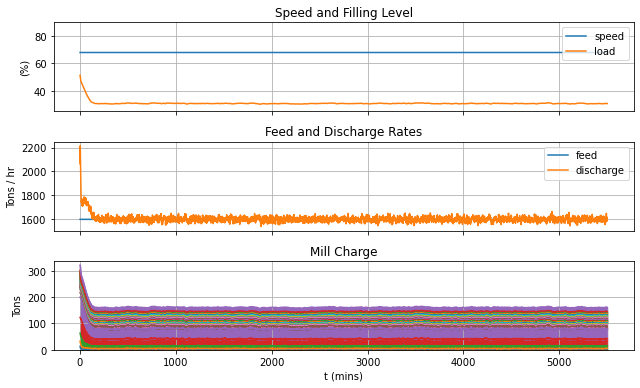

In [39]:
plot_sim_results(sim_data, filename = f"sim_time_series_{nt}.pdf")

In [42]:
charge_cols = [s for s in sim_data if s.startswith('Internal Charge')]
feed_cols = [s for s in sim_data if s.startswith('Make-up Feed')]

# Ignore the first 1000 timesteps
k_start = 1000
u_data = sim_data.loc[k_start:, feed_cols]
x_data = sim_data.loc[k_start:, charge_cols]
assert u_data.shape == (10000, 25)
assert x_data.shape == u_data.shape